In [1]:
import pandas as pd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


Two options here:

1. Looking for a timeseries chart similar to the forecasting chart below. I personally don't like how the forecast line starts from 2016. If we can cut the forecast line/confidence interval and just show the forecast line/confidence interval from Oct 2022 - Oct 2023, that would be great. Any formatting + UI enhancements are more than welcome (axis units, graph title, etc.). Use any package or visualizaiton tool that you are most comfortable in (python aitaire, plotly, bokeh, tableau, power BI, etc.)

2. You may be able to do things with the method of the prophet model object (ex. fig = model.plot(forecast)). Unsure what other parameters you can pass in here, but may be worth taking a look. 

In [5]:
all_data = pd.read_csv('../model_building/cleaned_data.csv')

# time series of just boise, id data
boise_data = all_data.loc[all_data.county_name == 'boise, id'][['date', 'median_listing_price']]

# forecast data from prophet for boise, id 
boise_forecast_data = pd.read_csv('data/prophet_forecast_boise_id.csv')

In [9]:
# yhat = forecast prediction
# yhat_lower = lower boundary of 95% confidence interval
# yhat_upper = upper boundary of 95% confidence interval 

boise_forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,yhat,yhat_lower,yhat_upper
0,230352.351602,133567.916587,3.275581e+05
1,201543.882653,110001.858180,2.941299e+05
2,202265.655549,111490.556747,2.885736e+05
3,207497.955712,114883.868619,2.947201e+05
4,224912.083581,131095.956256,3.263463e+05
...,...,...,...
82,826790.593057,739442.103584,9.205774e+05
83,738947.107105,651176.515712,8.258300e+05
84,808785.142738,724152.531511,9.064888e+05
85,928315.128100,834616.531039,1.013940e+06


21:05:13 - cmdstanpy - INFO - Chain [1] start processing
21:05:13 - cmdstanpy - INFO - Chain [1] done processing
21:05:13 - cmdstanpy - INFO - Chain [1] start processing
21:05:20 - cmdstanpy - INFO - Chain [1] done processing
21:05:20 - cmdstanpy - INFO - Chain [1] start processing
21:05:25 - cmdstanpy - INFO - Chain [1] done processing
21:05:25 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1] done processing


boise, id


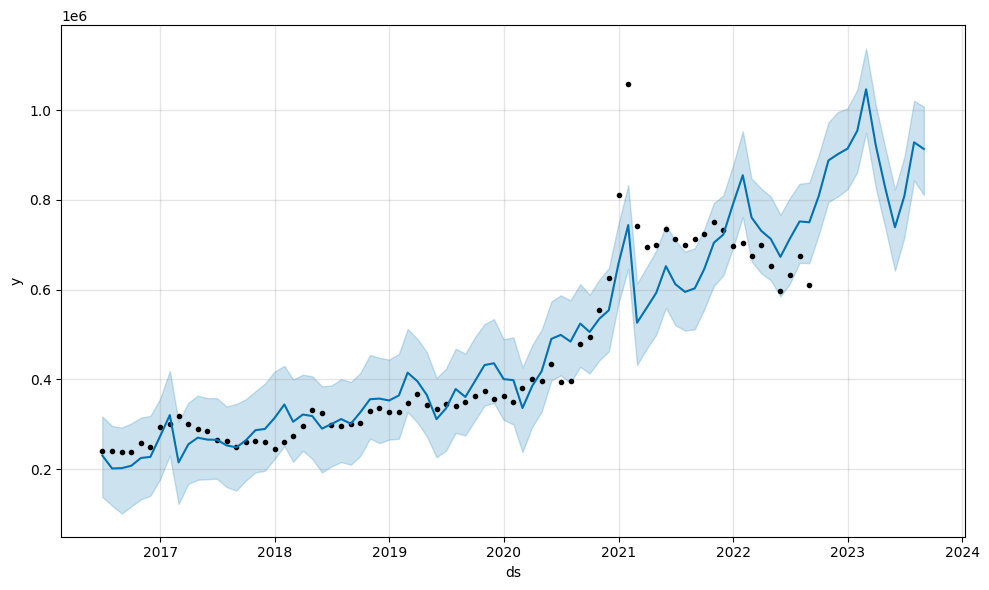

In [4]:
def model_for_county(county, data):
    """
    Creating model for a county given time series data of price and other county metrics over time

    return: prophet model object
    """

    county_data = data.loc[data.county_name == county][['date', 'median_listing_price', 'active_listing_count', 'median_days_on_market', 'thirty_year_interest_rate_four']]

    # adding lockdowns as holidays to prevent model from trying to model anomoly data
    lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    ])

    for t_col in ['ds', 'ds_upper']:
        lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
    lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

    county_data.columns = ['ds', 'y', 'active_listing_count', 'median_days_on_market', 'thirty_year_interest_rate_four']

    # instantiate Prophet model object with confidence interval with of 95%
    m = Prophet(seasonality_mode='multiplicative', holidays = lockdowns, interval_width = 0.95)

    m = Prophet(seasonality_mode='multiplicative', interval_width = 0.95)
    
    # adding additional regressor
    m.add_regressor('active_listing_count')
    m.add_regressor('median_days_on_market')
    # m.add_regressor('5yr_interest_rate')
    # m.add_regressor('15yr_interest_rate')
    m.add_regressor('thirty_year_interest_rate_four')
    m.fit(county_data)

    return m

def add_regressor_column(regressor_name, county, months_to_forecast):
    """
    forecast additional time series variables like active listing count median days on market

    return: list of forecasted values
    """
    county_data = data.loc[data.county_name == county][['date', regressor_name]]

    # adding lockdowns as holidays to prevent model from trying to model anomoly data
    lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
    ])

    for t_col in ['ds', 'ds_upper']:
        lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
    lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

    county_data.columns = ["ds", "y"]

    # instantiate Prophet model object with confidence interval with of 95%
    m = Prophet(seasonality_mode='multiplicative', holidays = lockdowns, interval_width = 0.95)
    
    m.fit(county_data)

    future = m.make_future_dataframe(periods=12, freq='MS')

    forecast = m.predict(future)

    return forecast.yhat



# reading in data
data = pd.read_csv('../model_building/cleaned_data.csv')

county = 'boise, id'

model = model_for_county(county, data)

# forecasting next 12 months for active listening count, median days on market, and thirty year interest rate lagged by 4 months
active_listing_count_regressor = add_regressor_column('active_listing_count', county, 12)
median_days_on_market_regressor = add_regressor_column('median_days_on_market', county, 12)
thirty_year_interest_regressor = add_regressor_column('thirty_year_interest_rate_four', county, 12)

# create data frame of future dates to make predictions for
future = model.make_future_dataframe(periods=12, freq='MS')
future['active_listing_count'] = active_listing_count_regressor
future['median_days_on_market'] = median_days_on_market_regressor
future['thirty_year_interest_rate_four'] = thirty_year_interest_regressor

# get forecast for future dates
forecast = model.predict(future)

# plotting forecast
fig = model.plot(forecast)
print(county)